In [30]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [31]:
from sklearn.preprocessing import OneHotEncoder

## Problem Statement

We're going to try to predict something about tiktok users from a dataset of the top 250 users.

Because our dataset is small, we're going to use cross validation to identify the best combination of parameters for each model.

## Read in data from GitHub

In [43]:
tiktok_path = "https://raw.githubusercontent.com/datares/TikTok_Famous/main/Datasets/Top%20Tiktokers%20Data%20Collection/top-250-tiktokers.csv"
tiktok_raw = pd.read_csv(tiktok_path).drop(columns = ['Rank','Brand Account','Views','LGBTQ']).set_index('Username')
tiktok = tiktok_raw.copy()

## Data Cleaning

In [44]:
genres = tiktok_raw.Genre.str.split(', ').to_list()
unique_genres = list(set([item.strip() for sublist in genres if sublist is not np.nan for item in sublist]))
for genre in unique_genres:
    tiktok[genre] = tiktok_raw.Genre.fillna('').str.contains(genre)

In [45]:
match = '\d*[.]?\d*'

tiktok['Followers'] = tiktok_raw['Followers'].apply(lambda x: float(re.findall(match, x)[0]))
tiktok['Likes'] = tiktok_raw['Likes'].apply(lambda x: float(re.findall(match, x)[0]))
tiktok['Engagement'] = tiktok_raw['Engagement'].apply(lambda x: float(re.findall('\d*[.]?\d*', x)[0]))

In [46]:
tiktok['Famous'] = tiktok['Famous'].fillna(0)
tiktok = tiktok.dropna()

In [47]:
categorical_vars = ['Country', 'Gender', 'Ethnicity']
tiktok = tiktok.join(pd.get_dummies(tiktok[categorical_vars]))

## Data Exploration

<AxesSubplot:>

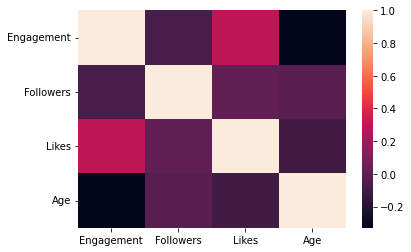

In [49]:
df = tiktok[['Engagement', 'Followers', 'Likes', 'Age']]
sns.heatmap(df.corr())

Text(0.5, 0, 'Age')

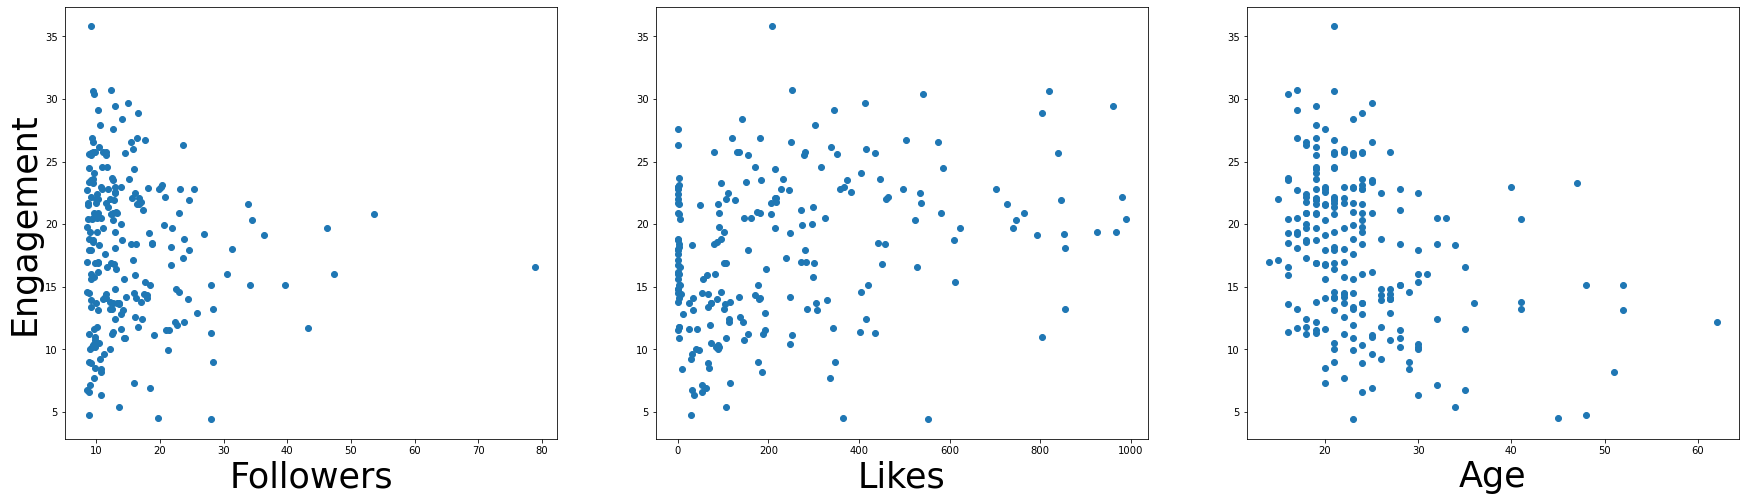

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.scatter(df.Followers, df.Engagement)
ax2.scatter(df.Likes, df.Engagement)
ax3.scatter(df.Age, df.Engagement)


plt.subplots_adjust(bottom=1.5, right=4, top=3)

ax1.set_xlabel('Followers', fontsize=35)
ax1.set_ylabel('Engagement', fontsize=35)
ax2.set_xlabel('Likes', fontsize=35) 
ax3.set_xlabel('Age', fontsize=35)

In [51]:
fig = px.box(tiktok, x="Famous", y="Engagement", title="Side by Side Boxplot of Engagement by Famous Status")
fig.show()

In [52]:
fig = px.box(tiktok, x="Gender", y="Engagement", title="Side by Side Boxplot of Engagement by Gender")
fig.show()

In [54]:
fig = px.box(tiktok, x="Ethnicity", y="Engagement", title="Side by Side Boxplot of Engagement by Ethnicity")
fig.show()

## Feature, Target Split

In [39]:
tiktok = tiktok.drop(columns=['Genre'] + categorical_vars)

In [40]:
X = tiktok.drop(columns=['Engagement'])
y = tiktok[['Engagement']]

## Model Fitting

In [41]:
from sklearn.linear_model import LinearRegression, ElasticNet, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [19]:
def fit_models(X, y):
    overall = {'poly__degree': [1,2,3], 'poly__interaction_only': [True,False]}
    models = {LinearRegression: {'model__positive': [True, False]},
              ElasticNet: {'model__alpha': [.25,.5,.75], 'model__l1_ratio': [.2,.25,.3,.5]},
              RandomForestRegressor: {'model__min_samples_split': [5], 'model__bootstrap': [True]},
              KNeighborsRegressor: {'model__n_neighbors': [5,8]}}
    regressors = {}
    
    for model, params in models.items():
        pipe  = Pipeline([('poly', PolynomialFeatures(interaction_only=True)),
                          ('scaler', StandardScaler()), 
                          ('model', model())])
        params.update(overall)
        cv = GridSearchCV(pipe, params, scoring='neg_mean_squared_error')
        cv.fit(X, y)
        regressors[model.__name__] = cv.best_estimator_
        print(model.__name__, ':', cv.best_params_)
        print('\tRMSE:', np.sqrt(np.abs(cv.best_score_)))
    return regressors

In [20]:
regressors = fit_models(X, y)

LinearRegression : {'model__positive': True, 'poly__degree': 1, 'poly__interaction_only': True}
	MSE: 5.23756711761202
ElasticNet : {'model__alpha': 0.25, 'model__l1_ratio': 0.3, 'poly__degree': 1, 'poly__interaction_only': True}
	MSE: 4.225298902980674
RandomForestRegressor : {'model__bootstrap': True, 'model__min_samples_split': 5, 'poly__degree': 3, 'poly__interaction_only': True}
	MSE: 4.383256365207112
KNeighborsRegressor : {'model__n_neighbors': 8, 'poly__degree': 1, 'poly__interaction_only': True}
	MSE: 4.571406147638456


Based on Cross Validation, our best model is ElasticNet

## Metrics/Evaluation

In [75]:
elastic_net = regressors['ElasticNet'].named_steps['model']

coefs = pd.DataFrame()
coefs['Name'] = ['Intercept'] + list(X.columns)
coefs['Coef'] = elastic_net.coef_
# coefs['Coef_abs'] = np.abs(elastic_net.coef_)

print(coefs.sort_values('Coef', ascending=False).head(5))
print(coefs.sort_values('Coef').head(5))

               Name      Coef
61  Ethnicity_White  0.651887
42   Country_Mexico  0.603186
11           Comedy  0.588943
2             Likes  0.422558
48    Country_Spain  0.412303
                     Name      Coef
40          Country_India -1.264562
59  Ethnicity_South Asian -1.234761
3                     Age -0.972484
12              Promotion -0.448534
31          Country_Aruba -0.417187
